# fig_AntRT

### This notebook generates figures for Figure: AntRT. 

Built from ccdt_explore_popHFA_grbBeh_isolateGroups

Figure 3:  Peristimulus baseline modulations encode anticipatory bias with and without endogenous RT  modulations
a) Methods for RT encoding
b) activation functions for three groups
c)  methods on measuring neural dynamics between stimulus and response 
d) Baseline vs. Speed  vs. Response modulation
c) bar plot showing ant bias across rt null, rt neg and rt pos populations
d) Scatter plot for baseline vs. anticipation bias

Ashwin G. Ramayya (ashwinramayya@gmail.com)
10/11/23

In [1]:
%%capture
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
import pingouin as pg

#FDR correction
from statsmodels.stats.multitest import multipletests as FDR
# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.size'] = 14
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/afig_AntRT/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
    #plt.savefig(fname = fig_dir+fname+'.png')


# Collect Group taskstats Data, filter and cluster
C = cc.Collection(collection_lbl='all')

# Boolean to identify good electrodes
goodElecsIdx = np.array(C.isBadElectrode_list)==False


C.doTaskStats_2d(pow_frange_lbl = 'HFA',
pow_method = 'wave',
pow_evQuery = 'error==0&fastResponse==0&badTrial==0',
do_zscore = True,
apply_gauss_smoothing = True,
gauss_sd_scaling = 0.075,
apply_time_bins=False,num_iters=1000,
time_bin_size_ms=100,overwriteFlag =False,feat_list_beh=['zrrtStoch'])

# get anatDif
#atlas='default'
atlas='yeo'
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas=atlas);


# get behavioral data (we will add columns to this dataframe throughout this notebook)
beh_df = C.getBehXSubj(evQuery='error==0&fastResponse==0', later_model_type = 'distance',\
                  later_model_strategy = 'DynamicBaseline')#'mean'

# here we  filter data to identify good elecs
C.filterElectrodes(filtE_bool=goodElecsIdx)

# cluster based on features (just for dependencies)
feat_option = 'selectivity_taskRt'
C.clusterElectrodesByTaskStats(feat_option=feat_option,binarize_stats=True,atlas=atlas)

# get ret idx    
ret_dict = C.groupElectrodesByTaskStats()

# initialize dictionary container (for collecting S-R dynamics)
sc_df_dict_grp = {}


# get target-locked pow
C.getPow_2d(pow_evType='FIX_START',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'error==0&fastResponse==0&badTrial==0',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False)

# create a shallow copy and get response-locked power
import copy
C2 = copy.copy(C)
C2.getPow_2d(pow_evType='RESPONSE',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'error==0&fastResponse==0&badTrial==0',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False)

# get errors
C_err = copy.copy(C)
C_err.getPow_2d(pow_evType='FIX_START',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'RT<0&delay==1500',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False)

# get errors
C2_err = copy.copy(C)
C2_err.getPow_2d(pow_evType='RESPONSE',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'RT<0&delay==1500',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False)

In [2]:
# subfunctions
def fdr_wrapper(p_list,lbls_list):
    # make sure there are no nans
    p_list = np.array(p_list)
    p_list[np.isnan(p_list)]=1
    reject,pvals_corrected,AS,AB =  FDR(pvals = p_list, alpha = 0.05,method = 'fdr_bh')

    #print('\n')
    #print('FDR-corrected p values')
    #print(np.hstack((np.array(lbls_list).squeeze()[:,np.newaxis],\
    #                 np.array(np.round(pvals_corrected,3)).squeeze()[:,np.newaxis])))
    
    return pvals_corrected

def genlbl(n,resid_str = ''):
    return 'popByDelay'+resid_str+'_'+n+'_diff'   

def doCorr_local(x,y,use_spearman=False):
    #remove nans and inf
    rm_bool = (np.isnan(x)) | (np.isnan(y)) | (np.isinf(x)) | (np.isinf(y)) 
    x = x[rm_bool==False]
    y = y[rm_bool==False]
    
    if (len(x) < 2) | (len(y) < 2):
        rval = np.nan
        pval = np.nan
    else:        
        if use_spearman == True:
            rval,pval = stats.spearmanr(x,y)
        else:
            rval,pval = stats.pearsonr(x,y)
    return rval,pval

def doCorrXGroup(sc_df_dict,n='SR_pathlengthMean',b='paramsDiff_D',plot_scatter=False):
    # containers 
    rvals = []
    pvals = []
    lbls = [] 

    for i in list(sc_df_dict.keys()):
        
        
        
        if len(sc_df_dict[i][genlbl(n)]) < 10:
            rval = 0
            pval = np.nan
        else:
            rval, pval = doCorr_local(sc_df_dict[i][genlbl(n)],sc_df_dict[i][b])
        rvals.append(rval)
        pvals.append(pval)
        lbls.append(i.split('-')[-1])
        
            
    f,ax = plt.subplots(1,1,figsize=(5,5))
    ax.bar(np.arange(0,len(sc_df_dict)),np.array(rvals),facecolor = '0.5',edgecolor = 'k',linewidth=2)
    plt.xticks(np.arange(0,len(sc_df_dict)),lbls,rotation=0)
    ax.set_ylim(-1,1)
    ax.set_title(n + ' vs. ' + b)
    plt.gca().set_ylabel('Pearson r')
    pvals_corrected = fdr_wrapper(pvals,list(sc_df_dict.keys()))
    
    # indicate significant values
    p_thresh = 0.05
    for i in np.arange(0,len(sc_df_dict)):
        if pvals_corrected[i]<=p_thresh:
            ax.text(i,1.25*rvals[i],'***')
            print(b,n,list(sc_df_dict.keys())[i],'corrected p:',np.round(pvals_corrected[i],3),\
                  'uncorrected p:',np.round(pvals[i],3))
    
        elif pvals[i]<=p_thresh:
            ax.text(i,1.25*rvals[i],'*')    
            print(b,n,list(sc_df_dict.keys())[i],'corrected p:',np.round(pvals_corrected[i],3),\
                  'uncorrected p:',np.round(pvals[i],3))           
        
     
    save_fig('bar-'+n+'-'+b)
    for i in np.arange(0,len(sc_df_dict)):
        
        
        if plot_scatter==True:
            C.plot_scatter(sc_df_dict[list(sc_df_dict.keys())[i]][b],sc_df_dict[list(sc_df_dict.keys())[i]][genlbl(n)],s=200);
            plt.gca().set_title(plt.gca().get_title()+' '+list(sc_df_dict.keys())[i])   
            plt.gca().set_xlabel(b)
            plt.gca().set_ylabel(n)   
            save_fig('scatter-'+list(sc_df_dict.keys())[i]+n+'-'+b)    
    
    # corr dict
    plot_dict = {}
    plot_dict['r'] = np.array(rvals)
    plot_dict['p'] = np.array(pvals)
    plot_dict['p_corrected'] = np.array(pvals_corrected)
    plot_dict['lbls'] = np.array(lbls)
    
    return plot_dict
def doPartialCorrXGroup_beh(sc_df_dict,n='SR_pathlengthMean',b='paramsDiff_D',b_control='paramsDiff_P'):
    # containers 
    rvals = []
    pvals = []

    for i in list(sc_df_dict.keys()):  
        
        if len(sc_df_dict[i][genlbl(n)]) < 10:
            rvals.append(0)
            pvals.append(np.nan)
        else:
            corrstats = pg.partial_corr(data = sc_df_dict[i], x=genlbl(n),y =b,covar = b_control,method='pearson')
            if np.isnan(corrstats['p-val'].to_numpy()[0]):
                rvals.append(0)
                pvals.append(np.nan)
            else:
                rvals.append(corrstats['r'].to_numpy()[0])
                pvals.append(corrstats['p-val'].to_numpy()[0])
        

    f,ax = plt.subplots(1,1)
    ax.bar(np.arange(0,len(sc_df_dict)),np.array(rvals),facecolor = '0.5',edgecolor = 'k')
    plt.xticks(np.arange(0,len(sc_df_dict)),list(sc_df_dict.keys()),rotation=90)
    ax.set_ylim(-1,1)
    ax.set_title(n + ' vs. ' + b + ' | ' + b_control)
    plt.gca().set_ylabel('Pearson Partial r')    
    pvals_corrected = fdr_wrapper(pvals,list(sc_df_dict.keys()))
    
    # indicate significant values
    p_thresh = 0.05
    for i in np.arange(0,len(sc_df_dict)):
        if pvals_corrected[i]<=p_thresh:
            plt.text(i-.3,rvals[i],'***')
            print(b,n,list(sc_df_dict.keys())[i],'corrected p:',np.round(pvals_corrected[i],3),\
                  'uncorrected p:',np.round(pvals[i],3))            
        elif pvals[i]<=p_thresh:
            plt.text(i,rvals[i],'*')    
            print(b,n,list(sc_df_dict.keys())[i],'corrected p:',np.round(pvals_corrected[i],3),\
                  'uncorrected p:',np.round(pvals[i],3))
    
def plotAct(ret_idx,yL = (-1,2),beh_feat = 'zrrt',atlas='default',min_subj = 5, min_elec=50,binByRT=True,delays_list=[500,1500]):

    
    # calc num subj
    n_subj = np.count_nonzero(C.collapseBySubj_1d(ret_idx))
    
    # create figure
    figsize=(10,5)
    f = plt.figure(figsize=figsize,facecolor='w') 


    # create subplots and axes
    gs = f.add_gridspec(nrows=2,ncols=6)
    ax_fix = f.add_subplot(gs[:,0:4])
    ax_resp = f.add_subplot(gs[:,4:])

    # plot targ-locked power
    C.evalClus_powByRT2d(ax = ax_fix,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=binByRT,delays_list=delays_list)
    ax_fix.legend().remove()
    ax_fix.set_xlabel('Time from target (ms)',fontsize=20)
    ax_fix.set_ylabel('HFA',fontsize=20)
    ax_fix.set_title('')
    ax_fix.set_yticks(np.linspace(yL[0],yL[1],4))
    ax_fix.set_yticklabels(np.round(ax_fix.get_yticks(),2),fontsize=20)
    ax_fix.set_title(('(n elec = '+str(np.count_nonzero(ret_idx))\
                         +'; n subj = '+str(n_subj)+')'),fontsize=20)
    #save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-targPow')

    # plot resp-locked power
    C2.evalClus_powByRT2d(ax=ax_resp,ret_idx = ret_idx,xL_ms=(-1000,1000),figsize=(5,5),yL=yL,binByRT=binByRT,delays_list=delays_list)
    ax_resp.legend().remove()
    ax_resp.set_title('')
    ax_resp.set_yticks((yL[0],yL[1]))
    ax_resp.set_yticklabels([],fontsize=20)
    ax_resp.set_xlabel('Time from response (ms)')
    ax_resp.set_ylabel('')
    #save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-timecourse'+str(delays_list)+str(binByRT))
def plotAnat(retIdx):
    # plot anat
    plot_dict = C.evalClus_anat(ax=None,ret_idx = ret_idx,use_colormap=True, plot_by_hemis = False,\
                    yL=None,title = str(np.count_nonzero(ret_idx)),\
                    fsize=(5,5),fsize_lbl=10,atlas=atlas,alpha_hline = (np.sum(ret_idx)/len(ret_idx)))
    plt.gca().set_title('')
    plt.gca().set_ylabel('% electrodes',fontsize=20)
    plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
    for r in plot_dict['roi_list']:
        print(r,plot_dict['binom_zvals'][plot_dict['roi_list'].index(r)])
    #save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-anat')#+atlas

In [3]:
# Here we choose electrodes that show rate of rise correlates of stochastic RT variability as predicted by LATER
p_thresh=0.05
n_feat_list = ['S0f','S0c','postCC','postCC_bur','preResponse_bur','preResponse']
beh_feat = 'zrrtStoch'

# any rt-related change
ret_idx_pos = np.zeros(len(C.taskstats2d_df)).astype('bool')
ret_idx_neg = np.zeros(len(C.taskstats2d_df)).astype('bool')

for n in n_feat_list:
    is_sig = (C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh)
    is_pos = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_rval'].to_numpy()>0
    is_neg = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_rval'].to_numpy()<0
    ret_idx_pos =  ret_idx_pos|(is_sig&is_pos)
    ret_idx_neg =  ret_idx_neg|(is_sig&is_neg)

    
 # here we compute statistics on toral number of RT predictive electrodes
is_sig = C.taskstats2d_df['rtRegress_multivar_'+beh_feat+'_SSE'+'_pvalnp'].to_numpy()
np.sum(is_sig)/len(ret_idx_pos)


print('Do we observe more significant electrodes than expected by chance?')
n_tot = len(is_sig)
n_obs = np.sum(is_sig)
n_exp = p_thresh*n_tot
chisq,p = stats.chisquare(f_obs=(n_obs,n_tot-n_obs), \
                              f_exp=(n_exp,n_tot-n_exp))
print('n obs/n tot', n_obs,n_tot)
print('freq of significant elecs',100*(n_obs/n_tot),'%')
print('n exp/n tot', n_exp,n_tot,100*(n_exp/n_tot),'%')
print('chi2stat',chisq,p)
print('\n')
overall_rate = n_obs/n_tot

Do we observe more significant electrodes than expected by chance?
n obs/n tot 931.3679999999999 2609
freq of significant elecs 35.69827520122652 %
n exp/n tot 130.45000000000002 2609 5.000000000000001 %
chi2stat 5176.168668971776 0.0




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Visual -1.0936007438238387
DorsalAttention -0.2555484180421888
Somatomotor -3.084475652735269
Default 1.2529038027814916
Limbic 2.870199447986036
Salience -0.0659568760122261
Frontoparietal -0.39182197247353345


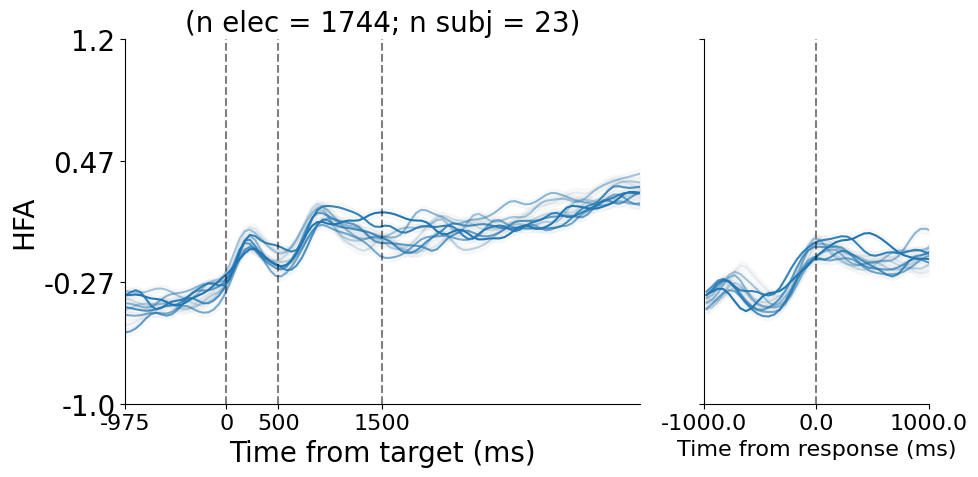

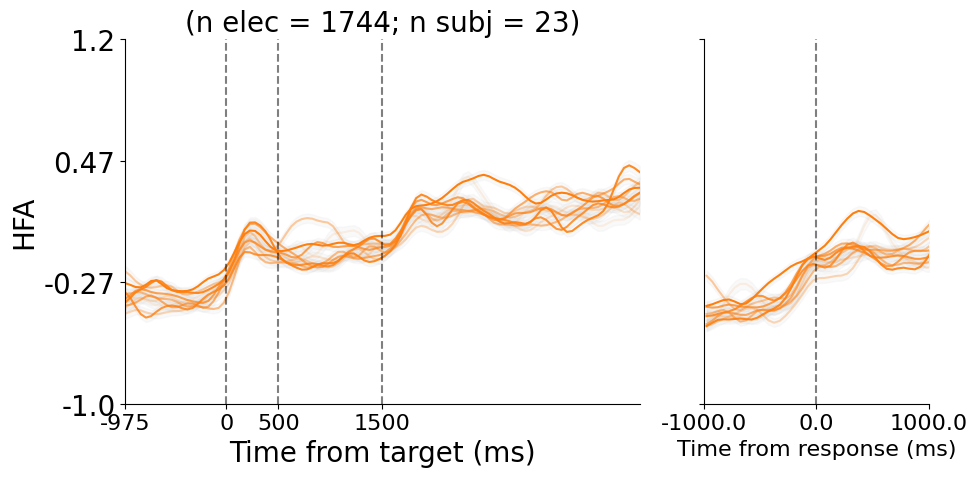

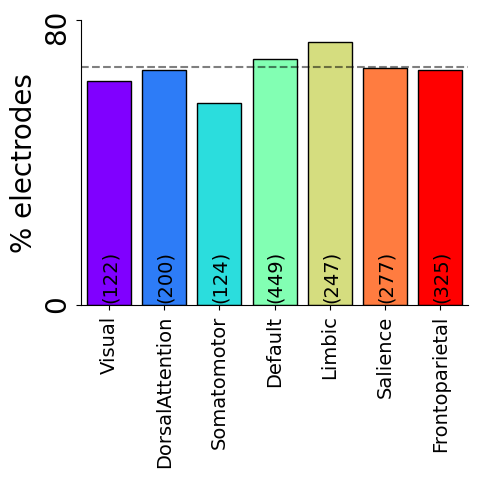

In [4]:
# first, rt null
ret_idx = (ret_idx_pos==False)&(ret_idx_neg==False)
ret_str = 'rtNull'

plotAct(ret_idx,yL = (-1,1.2),beh_feat = 'zrrtStoch',atlas='yeo',min_subj = 5, min_elec=50,binByRT=True,delays_list=[500])
save_fig(ret_str+'-actFunc-short')
plotAct(ret_idx,yL = (-1,1.2),beh_feat = 'zrrtStoch',atlas='yeo',min_subj = 5, min_elec=50,binByRT=True,delays_list=[1500])
save_fig(ret_str+'-actFunc-long')
plotAnat(ret_idx)
save_fig(ret_str+'-anat-'+atlas)


# now we collect S-R dynamics for this electrode group prestimulus baseline differences
#filter bool
filter_bool = 'IsolateFunction-'+'-'+ret_str

#load it
sc_df_dict_grp[filter_bool] = C.getSubjCollectionDf(filter_bool =C.retIdx2masterRetIdx(ret_idx),filter_bool_lbl =filter_bool, \
                                                    min_obs_thresh = 1,popStats_iters = 1)
# merge beh df
sc_df_dict_grp[filter_bool] =  sc_df_dict_grp[filter_bool].join(beh_df,lsuffix='_old',rsuffix='')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Visual -1.3729328119137048
DorsalAttention 0.6861158336275165
Somatomotor 3.379607503761162
Default -0.4801068333382059
Limbic -2.1628972891200964
Salience 0.6599862140102207
Frontoparietal 0.06206735909332799


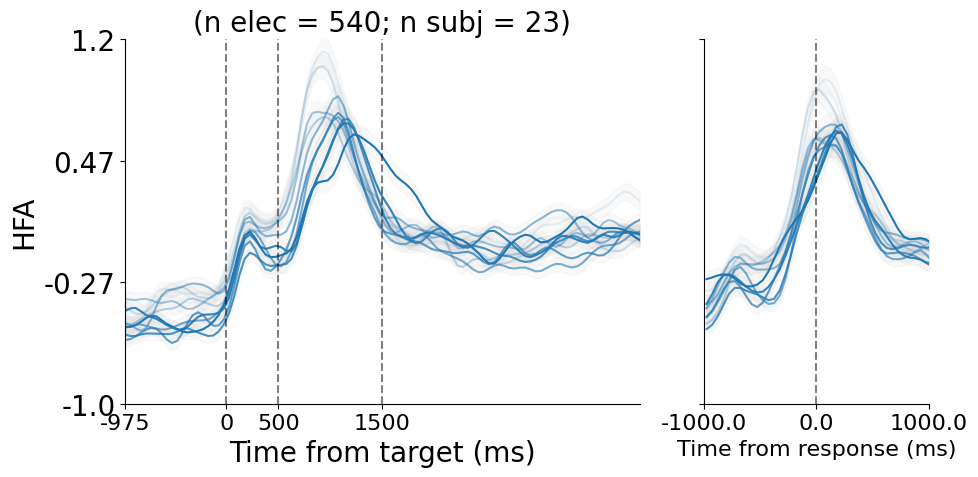

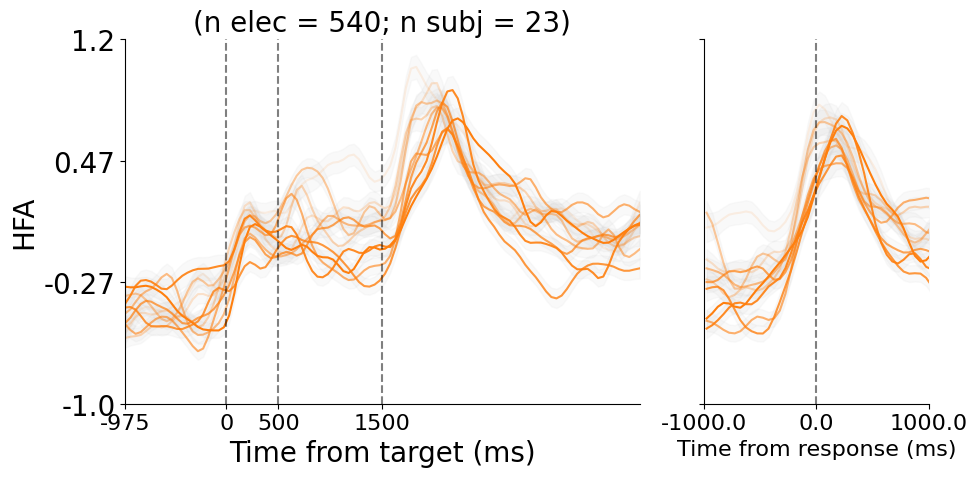

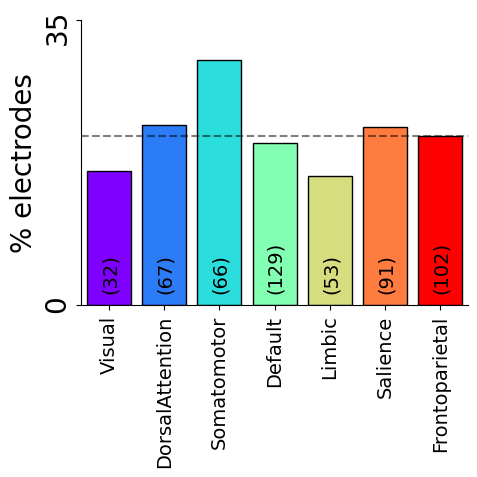

In [5]:
# next, RT neg
ret_idx = ret_idx_neg
ret_str = 'rtNeg'

plotAct(ret_idx,yL = (-1,1.2),beh_feat = 'zrrtStoch',atlas='yeo',min_subj = 5, min_elec=50,binByRT=True,delays_list=[500])
save_fig(ret_str+'-actFunc-short')
plotAct(ret_idx,yL = (-1,1.2),beh_feat = 'zrrtStoch',atlas='yeo',min_subj = 5, min_elec=50,binByRT=True,delays_list=[1500])
save_fig(ret_str+'-actFunc-long')
plotAnat(ret_idx)
save_fig(ret_str+'-anat-'+atlas)


# now we collect S-R dynamics for this electrode group prestimulus baseline differences
#filter bool
filter_bool = 'IsolateFunction-'+'-'+ret_str

#load it
sc_df_dict_grp[filter_bool] = C.getSubjCollectionDf(filter_bool =C.retIdx2masterRetIdx(ret_idx),filter_bool_lbl =filter_bool, \
                                                    min_obs_thresh = 1,popStats_iters = 1)
# merge beh df
sc_df_dict_grp[filter_bool] =  sc_df_dict_grp[filter_bool].join(beh_df,lsuffix='_old',rsuffix='')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Visual 2.881628236718459
DorsalAttention 0.07340358257697872
Somatomotor 2.577215822134464
Default -1.4929872398910788
Limbic -1.9337912379883648
Salience 0.5205312366611363
Frontoparietal -0.5136308972654903


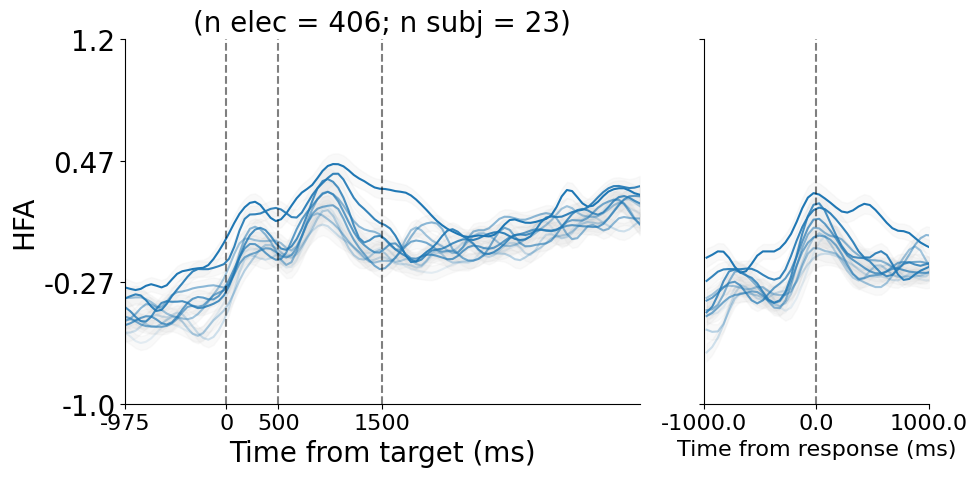

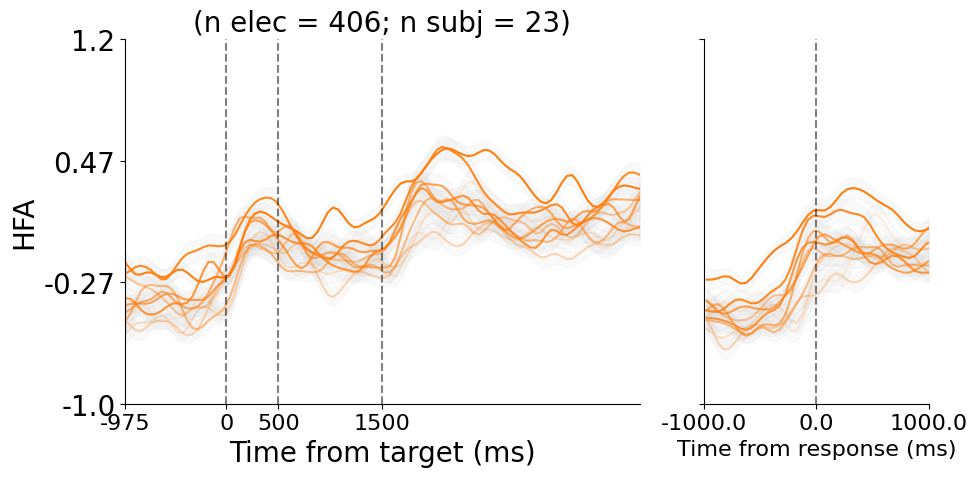

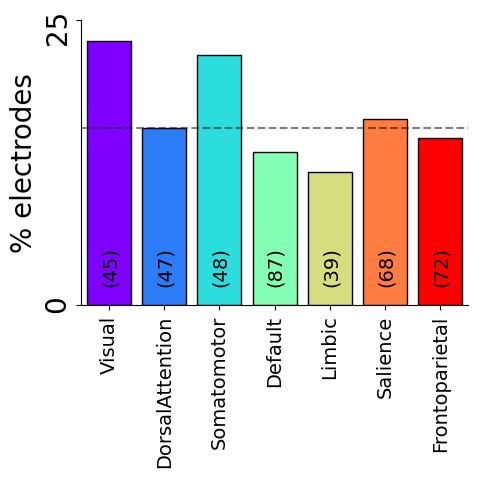

In [6]:
# next, RT pos
ret_idx = ret_idx_pos
ret_str = 'rtPos'

plotAct(ret_idx,yL = (-1,1.2),beh_feat = 'zrrtStoch',atlas='yeo',min_subj = 5, min_elec=50,binByRT=True,delays_list=[500])
save_fig(ret_str+'-actFunc-short')
plotAct(ret_idx,yL = (-1,1.2),beh_feat = 'zrrtStoch',atlas='yeo',min_subj = 5, min_elec=50,binByRT=True,delays_list=[1500])
save_fig(ret_str+'-actFunc-long')
plotAnat(ret_idx)
save_fig(ret_str+'-anat-'+atlas)

# now we collect S-R dynamics for this electrode group prestimulus baseline differences
#filter bool
filter_bool = 'IsolateFunction-'+'-'+ret_str

#load it
sc_df_dict_grp[filter_bool] = C.getSubjCollectionDf(filter_bool =C.retIdx2masterRetIdx(ret_idx),filter_bool_lbl =filter_bool, \
                                                    min_obs_thresh = 1,popStats_iters = 1)
# merge beh df
sc_df_dict_grp[filter_bool] =  sc_df_dict_grp[filter_bool].join(beh_df,lsuffix='_old',rsuffix='')

rtDiff_mean S0cenMean IsolateFunction--rtNull corrected p: 0.02 uncorrected p: 0.007
rtDiff_mean S0cenMean IsolateFunction--rtNeg corrected p: 0.029 uncorrected p: 0.019


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)


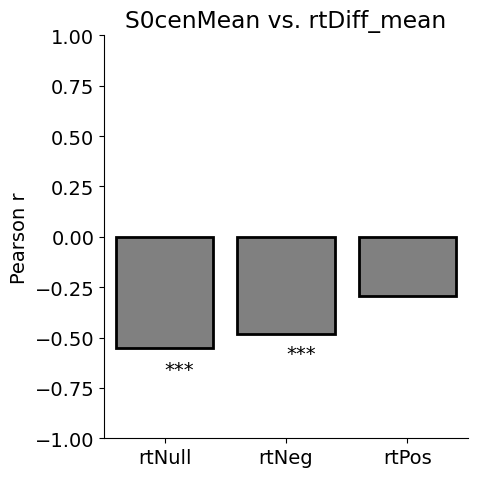

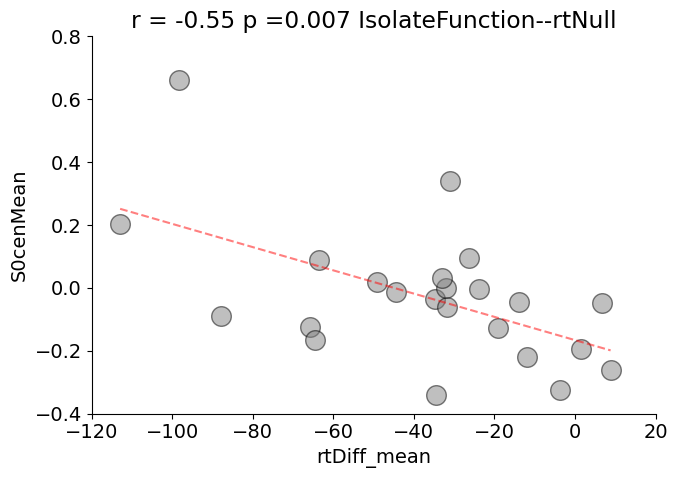

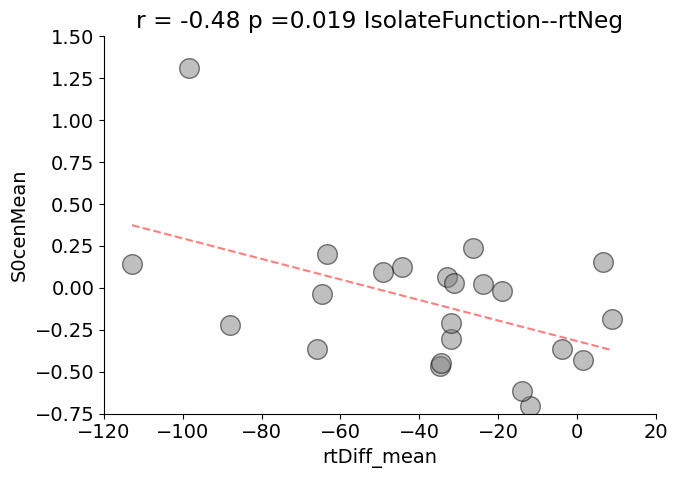

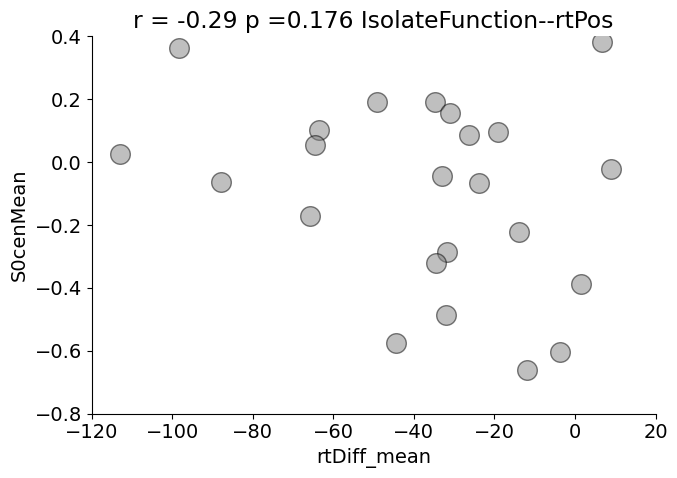

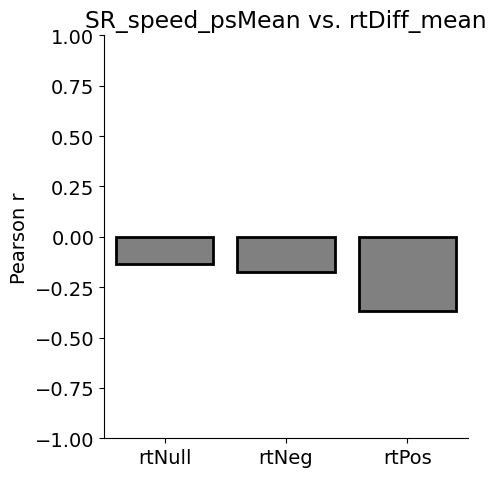

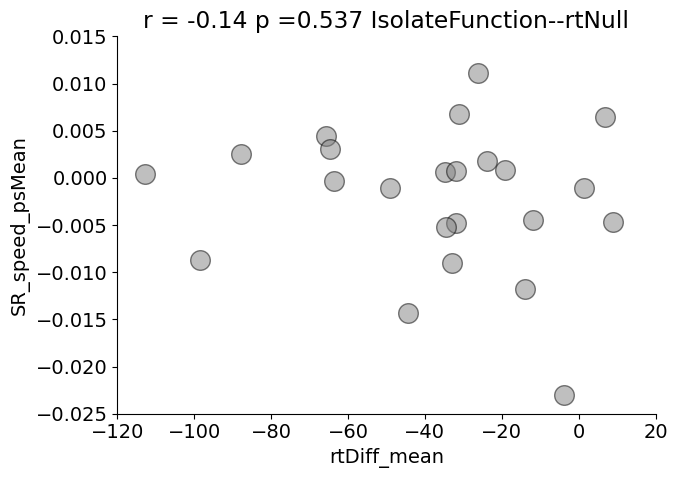

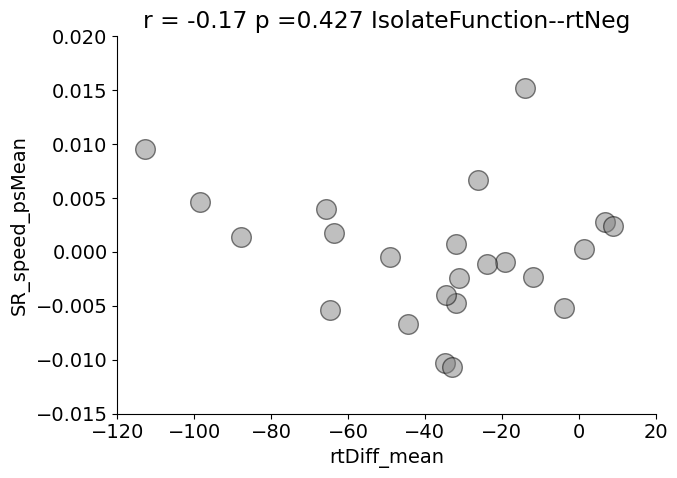

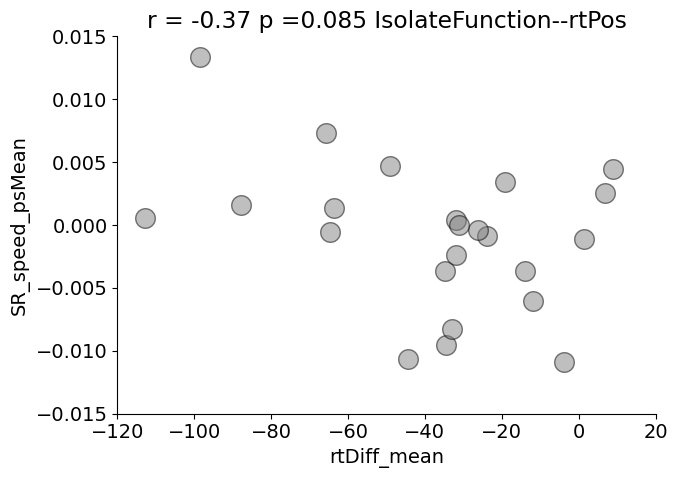

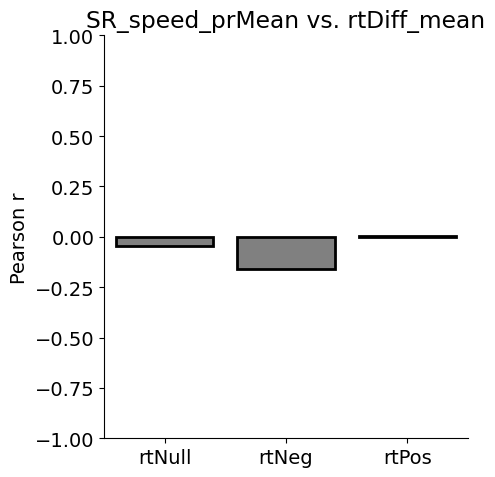

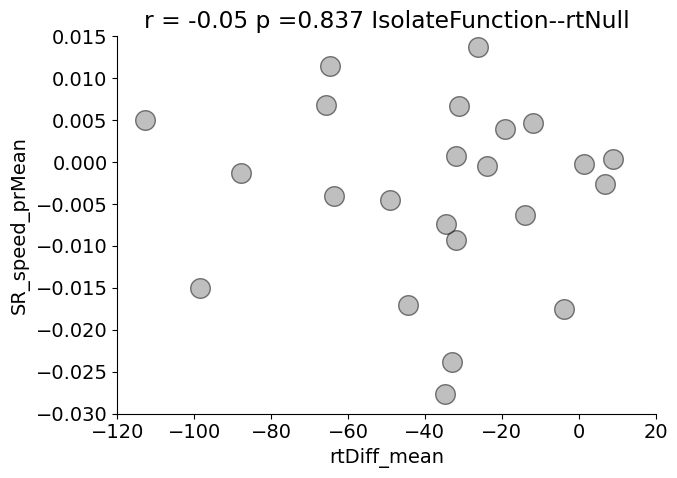

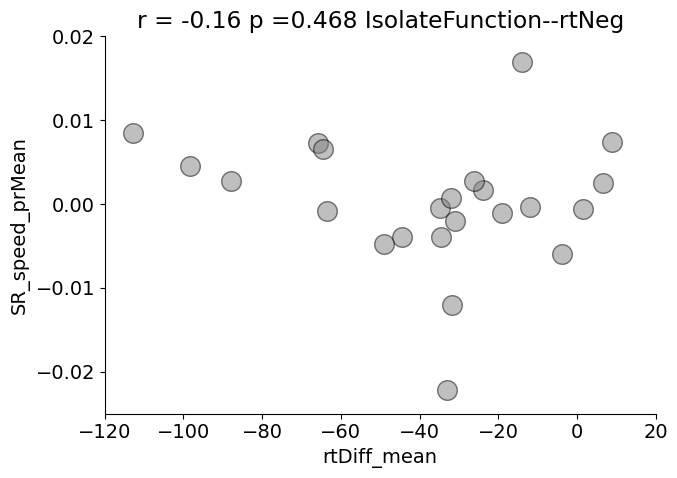

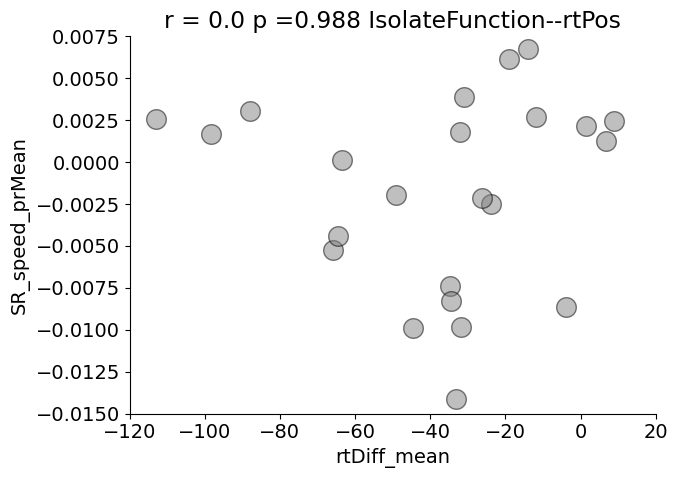

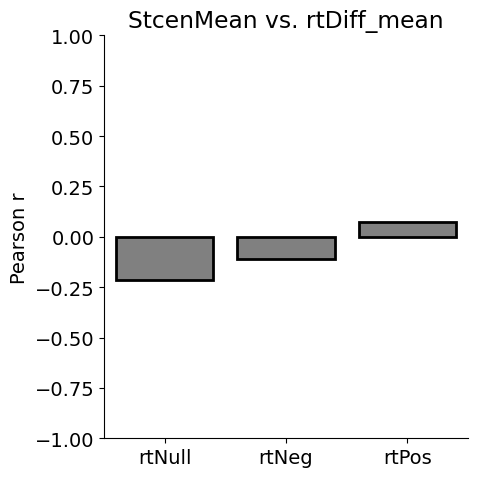

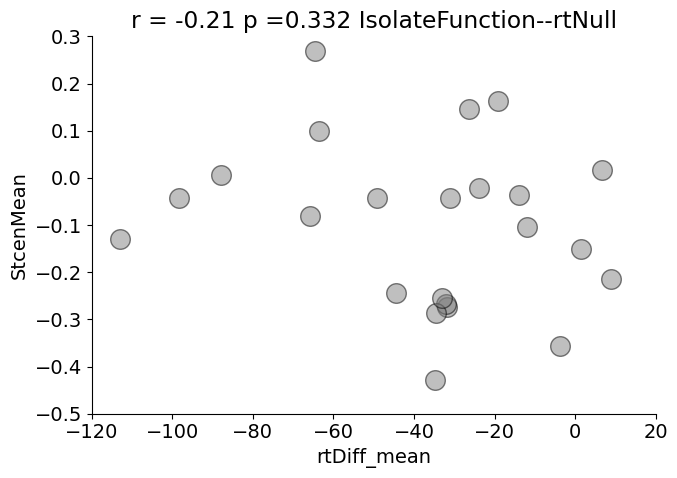

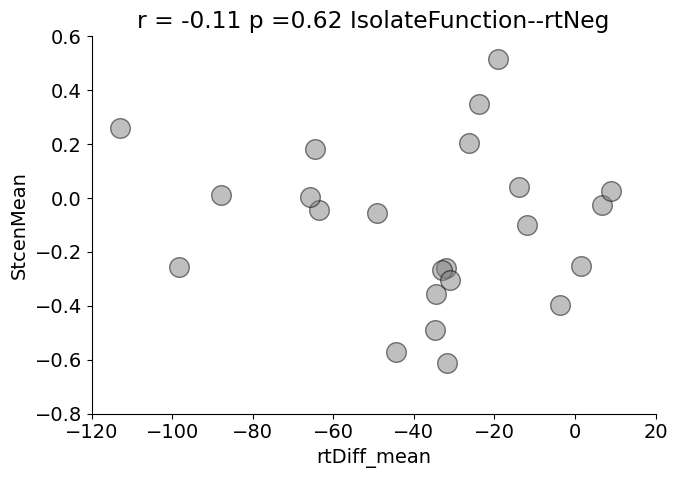

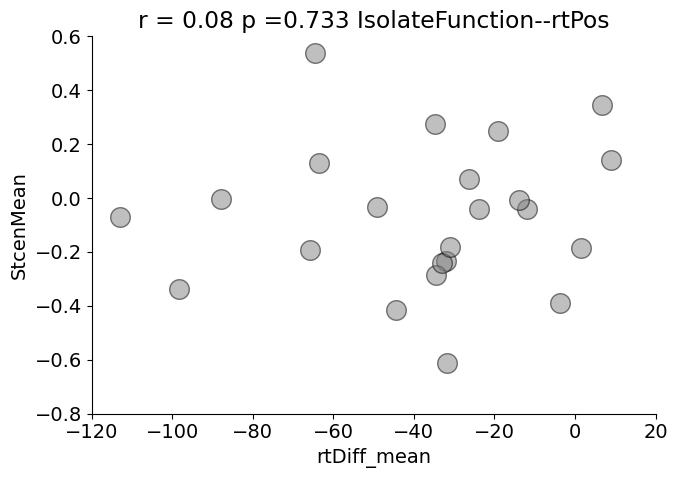

In [8]:
# bar plot
neu_feat_list_static =['S0cenMean','SR_speed_psMean','SR_speed_prMean','StcenMean']#

#neu_feat_list_static =['S0cenMean','SR_speed_psMean','StcenMean']#

for n in neu_feat_list_static:
    plot_dict1 = doCorrXGroup(sc_df_dict_grp,n=n,b='rtDiff_mean',plot_scatter=True);